In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import sampler
from torch.utils.data import DataLoader

import torchvision.datasets as dset
import torchvision.transforms as T

import timeit

import models
import solver
import views

In [3]:
dtype = torch.FloatTensor
if torch.cuda.is_available():
    dtype = torch.cuda.FloatTensor

print_every = 100

def reset(m):
    if hasattr(m, 'reset_parameters'):
        m.reset_parameters()
    
    
def show_solver_training(solver):
    views.show_traning(solver.loss_history, solver.train_acc_history, solver.val_acc_history)

    
def show_mean_and_std_hist(parameters):
    paras = [w.data.cpu().numpy() for w in parameters]
    views.plot_mean_std_hist(paras)

    
def show_conv_layer_weights(conv_weights):
    conv_weights = conv_weights.data.cpu().numpy()
    conv_weights = conv_weights.transpose(0, 2, 3, 1)
    views.show_conv_weights(conv_weights)

    
def compare_solvers_tranings(solvers_with_labels):
    loss_train_val_acc_with_labels = {}
    for label, solver in solvers_with_labels.items():
        loss_train_val_acc_with_labels[label] = (solver.loss_history, solver.train_acc_history, solver.val_acc_history)
    
    views.compare_trainings(loss_train_val_acc_with_labels)

def compare_training_stats(train_stats):
    loss_train_val_acc_with_labels = { }
    
    for (lr, reg) in train_stats:
        train_acc, val_acc, loss_history = train_stats[(lr, reg)]
        loss_train_val_acc_with_labels[str(lr) + ' ' + str(reg)] = (loss_history, train_acc, val_acc)
    
    views.compare_trainings(loss_train_val_acc_with_labels)


In [4]:
class ChunkSampler(sampler.Sampler):
    """Samples elements sequentially from some offset.
    Arguments:
        num_samples: # of desired datapoints
        start: offset where we should start selecting from"""
    def __init__(self, num_samples, start=0):
        self.num_samples = num_samples
        self.start = start
        
    def __iter__(self):
        return iter(range(self.start, self.start + self.num_samples))
    
    def __len__(self):
        return self.num_samples
    
NUM_TRAIN = 49000
NUM_VAL = 1000

NUM_TRAIN_SMALL = 64

cifar10_train_small = dset.CIFAR10('../cs231n/datasets/', train=True, download=True, transform=T.ToTensor())
loader_train_small = DataLoader(cifar10_train_small, batch_size=64, sampler=ChunkSampler(NUM_TRAIN_SMALL, 0))

cifar10_train = dset.CIFAR10('../cs231n/datasets/', train=True, download=True, transform=T.ToTensor())
loader_train = DataLoader(cifar10_train, batch_size=64, sampler=ChunkSampler(NUM_TRAIN, 0))

cifar10_val = dset.CIFAR10('../cs231n/datasets/', train=True, download=True, transform=T.ToTensor())
# cifar10_val = cifar10_train # can do this?
loader_val = DataLoader(cifar10_val, batch_size=64, sampler=ChunkSampler(NUM_VAL, NUM_TRAIN))

cifar10_test = dset.CIFAR10('../cs231n/datasets/', train=False, download=True, transform=T.ToTensor())
loader_test = DataLoader(cifar10_test, batch_size=64)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


# 1. Train base net

In [7]:
torch.cuda.random.manual_seed(12345)

#
base_model = models.BaseNet().type(dtype)
base_loss_fn = nn.CrossEntropyLoss().type(dtype)

lr = 1e-3
reg = 1e-6
step_size = 10
gamma = 0.2
num_epochs = 10

base_optimizer = optim.SGD(base_model.parameters(), lr=lr, momentum=0.9, weight_decay=reg)
base_lr_scheduler = lr_scheduler.StepLR(base_optimizer, step_size=step_size, gamma=gamma)

base_solver = solver.ClassificationSolver(loader_train=loader_train, loader_val=loader_val,
                                          model=base_model,
                                          loss_fn=base_loss_fn,
                                          optimizer=base_optimizer,
                                          scheduler=base_lr_scheduler,
                                          dtype=dtype,
                                          num_epochs=num_epochs,
                                          verbose=True
                                         )

base_solver.train()

t = 0, loss = 2.2971
t = 100, loss = 2.2689
t = 200, loss = 2.0912
t = 300, loss = 2.1538
t = 400, loss = 2.0910
t = 500, loss = 1.9915
t = 600, loss = 2.0989
t = 700, loss = 1.8476
(Epoch 0 / 10) train acc: 0.367188; val acc: 0.348000
t = 0, loss = 1.8920
t = 100, loss = 1.8151
t = 200, loss = 1.6393
t = 300, loss = 1.8745
t = 400, loss = 1.8134
t = 500, loss = 1.7490
t = 600, loss = 1.8578
t = 700, loss = 1.6022
(Epoch 1 / 10) train acc: 0.428711; val acc: 0.418000
t = 0, loss = 1.6417
t = 100, loss = 1.6389
t = 200, loss = 1.4131
t = 300, loss = 1.6733
t = 400, loss = 1.5826
t = 500, loss = 1.6099
t = 600, loss = 1.7022
t = 700, loss = 1.4854
(Epoch 2 / 10) train acc: 0.474609; val acc: 0.480000
t = 0, loss = 1.4926
t = 100, loss = 1.5534
t = 200, loss = 1.2647
t = 300, loss = 1.5878
t = 400, loss = 1.4106
t = 500, loss = 1.5559
t = 600, loss = 1.5675
t = 700, loss = 1.4200
(Epoch 3 / 10) train acc: 0.495117; val acc: 0.517000
t = 0, loss = 1.3822
t = 100, loss = 1.4870
t = 200, los

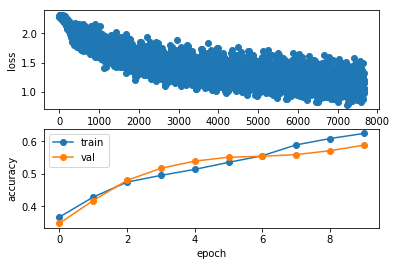

In [9]:
show_solver_training(base_solver)

## 1.1 minus different base net? without fc-bn

In [48]:
torch.cuda.random.manual_seed(12345)

#
base_model1 = models.BaseNet1().type(dtype)
base_loss_fn1 = nn.CrossEntropyLoss().type(dtype)

lr = 1e-3
reg = 1e-6
step_size = 10
gamma = 0.2
num_epochs = 10

base_optimizer1 = optim.SGD(base_model1.parameters(), lr=lr, momentum=0.9, weight_decay=reg)
base_lr_scheduler1 = lr_scheduler.StepLR(base_optimizer1, step_size=step_size, gamma=gamma)

base_solver1 = solver.ClassificationSolver(loader_train=loader_train, loader_val=loader_val,
                                          model=base_model1,
                                          loss_fn=base_loss_fn1,
                                          optimizer=base_optimizer1,
                                          scheduler=base_lr_scheduler1,
                                          dtype=dtype,
                                          num_epochs=num_epochs,
                                          verbose=True
                                         )

base_solver1.train()

t = 0, loss = 2.2901
t = 100, loss = 2.2152
t = 200, loss = 1.9495
t = 300, loss = 2.0912
t = 400, loss = 2.0976
t = 500, loss = 1.9498
t = 600, loss = 2.0495
t = 700, loss = 1.7843
(Epoch 0 / 10) train acc: 0.373047; val acc: 0.389000
t = 0, loss = 1.8056
t = 100, loss = 1.7516
t = 200, loss = 1.6082
t = 300, loss = 1.8019
t = 400, loss = 1.7538
t = 500, loss = 1.7104
t = 600, loss = 1.7889
t = 700, loss = 1.5743
(Epoch 1 / 10) train acc: 0.445312; val acc: 0.461000
t = 0, loss = 1.6089
t = 100, loss = 1.5935
t = 200, loss = 1.3354
t = 300, loss = 1.5994
t = 400, loss = 1.4881
t = 500, loss = 1.6161
t = 600, loss = 1.6240
t = 700, loss = 1.4768
(Epoch 2 / 10) train acc: 0.475586; val acc: 0.501000
t = 0, loss = 1.4813
t = 100, loss = 1.5541
t = 200, loss = 1.2093
t = 300, loss = 1.5109
t = 400, loss = 1.3775
t = 500, loss = 1.6063
t = 600, loss = 1.5504
t = 700, loss = 1.4490
(Epoch 3 / 10) train acc: 0.495117; val acc: 0.519000
t = 0, loss = 1.4093
t = 100, loss = 1.5098
t = 200, los

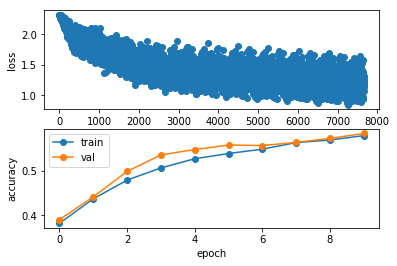

In [20]:
show_solver_training(base_solver1)

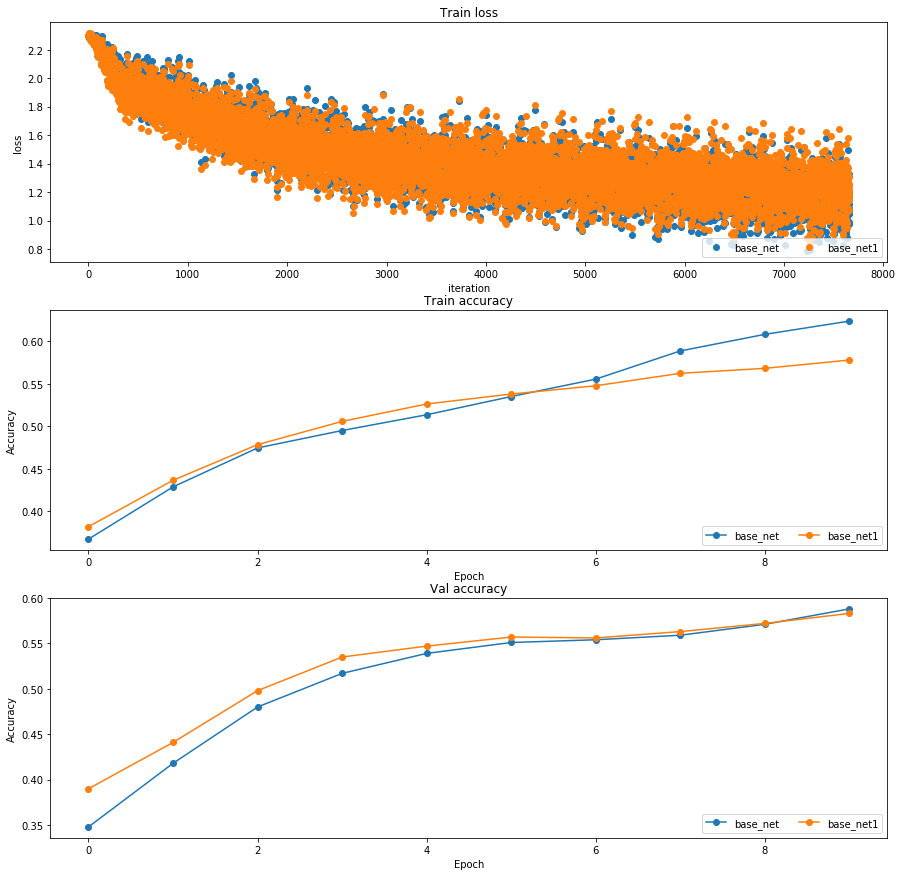

In [21]:
compare_solvers_tranings({'base_net': base_solver, 'base_net1': base_solver1})

# 2. with batch norm

In [5]:
torch.cuda.random.manual_seed(12345)

#
bn_model = models.BatchNormNet().type(dtype)
bn_loss_fn = nn.CrossEntropyLoss().type(dtype)

lr = 1e-3
reg = 1e-6
step_size = 10
gamma = 0.2
num_epochs = 20

bn_optimizer = optim.SGD(bn_model.parameters(), lr=lr, momentum=0.9, weight_decay=reg)
bn_lr_scheduler = lr_scheduler.StepLR(bn_optimizer, step_size=step_size, gamma=gamma)

bn_solver = solver.ClassificationSolver(loader_train=loader_train, loader_val=loader_val,
                                          model=bn_model,
                                          loss_fn=bn_loss_fn,
                                          optimizer=bn_optimizer,
                                          scheduler=bn_lr_scheduler,
                                          dtype=dtype,
                                          num_epochs=num_epochs,
                                          verbose=True
                                         )

bn_solver.train()

t = 0, loss = 2.4498
t = 100, loss = 1.5539
t = 200, loss = 1.2073
t = 300, loss = 1.4206
t = 400, loss = 1.3387
t = 500, loss = 1.5248
t = 600, loss = 1.3879
t = 700, loss = 1.2453
(Epoch 0 / 20) train acc: 0.591797; val acc: 0.551000
t = 0, loss = 1.2764
t = 100, loss = 1.1687
t = 200, loss = 0.8249
t = 300, loss = 1.1494
t = 400, loss = 1.0073
t = 500, loss = 1.2488
t = 600, loss = 1.0942
t = 700, loss = 1.0188
(Epoch 1 / 20) train acc: 0.628906; val acc: 0.575000
t = 0, loss = 1.0886
t = 100, loss = 0.9408
t = 200, loss = 0.6606
t = 300, loss = 0.9627
t = 400, loss = 0.8607
t = 500, loss = 1.0400
t = 600, loss = 0.9081
t = 700, loss = 0.8632
(Epoch 2 / 20) train acc: 0.697266; val acc: 0.636000
t = 0, loss = 0.8476
t = 100, loss = 0.7945
t = 200, loss = 0.5228
t = 300, loss = 0.7837
t = 400, loss = 0.7826
t = 500, loss = 0.8354
t = 600, loss = 0.7362
t = 700, loss = 0.7742
(Epoch 3 / 20) train acc: 0.660156; val acc: 0.593000
t = 0, loss = 0.6326
t = 100, loss = 0.6129
t = 200, los

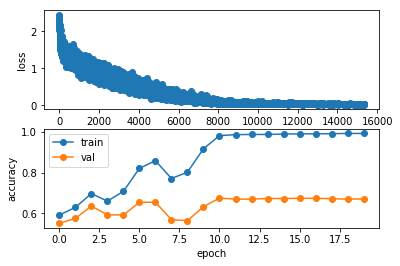

In [10]:
show_solver_training(bn_solver)

## compare with base net

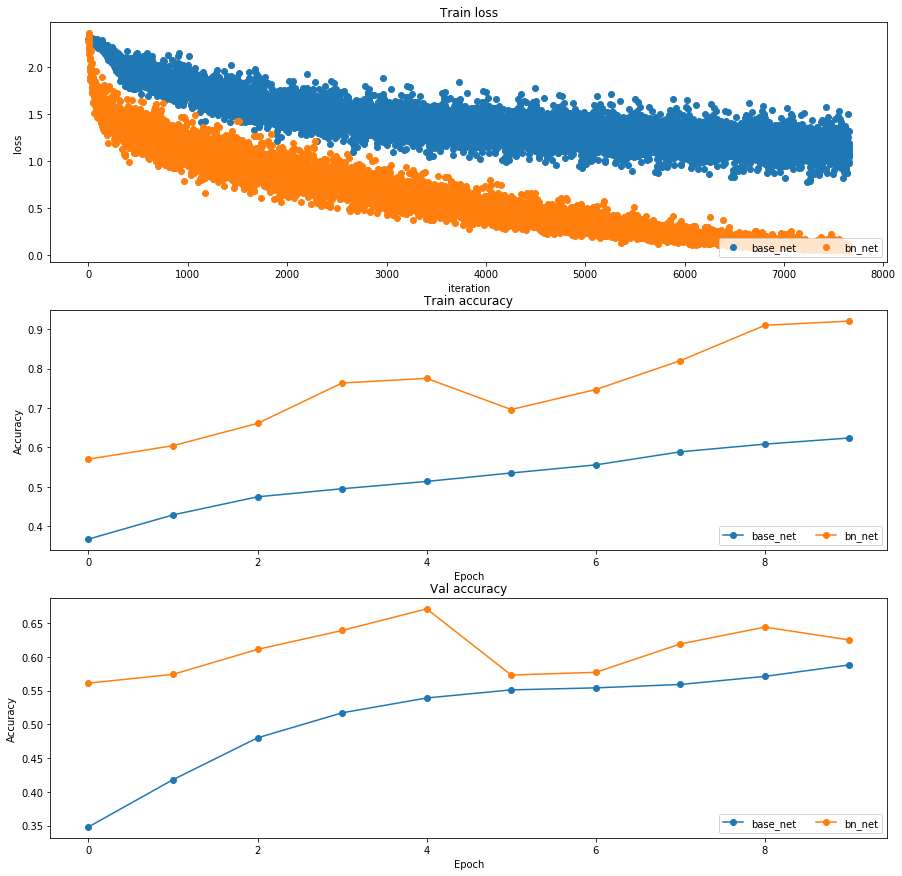

In [25]:
compare_solvers_tranings({"base_net": base_solver, "bn_net": bn_solver})

## 2.1 minus different bn net, but with huge difference in train_acc

In [11]:
torch.cuda.random.manual_seed(12345)

#
bn_model1 = models.BatchNormNet1().type(dtype)
bn_loss_fn1 = nn.CrossEntropyLoss().type(dtype)

lr = 1e-3
reg = 1e-6
step_size = 10
gamma = 0.2
num_epochs = 20

bn_optimizer1 = optim.SGD(bn_model1.parameters(), lr=lr, momentum=0.9, weight_decay=reg)
bn_lr_scheduler1 = lr_scheduler.StepLR(bn_optimizer1, step_size=step_size, gamma=gamma)

bn_solver1 = solver.ClassificationSolver(loader_train=loader_train, loader_val=loader_val,
                                          model=bn_model1,
                                          loss_fn=bn_loss_fn1,
                                          optimizer=bn_optimizer1,
                                          scheduler=bn_lr_scheduler1,
                                          dtype=dtype,
                                          num_epochs=num_epochs,
                                          verbose=True
                                         )

bn_solver1.train()

t = 0, loss = 2.2973
t = 100, loss = 1.7170
t = 200, loss = 1.3498
t = 300, loss = 1.5617
t = 400, loss = 1.4035
t = 500, loss = 1.6006
t = 600, loss = 1.4738
t = 700, loss = 1.3707
(Epoch 0 / 20) train acc: 0.522461; val acc: 0.523000
t = 0, loss = 1.3122
t = 100, loss = 1.2503
t = 200, loss = 0.9572
t = 300, loss = 1.2323
t = 400, loss = 1.0685
t = 500, loss = 1.3918
t = 600, loss = 1.1493
t = 700, loss = 1.1614
(Epoch 1 / 20) train acc: 0.522461; val acc: 0.517000
t = 0, loss = 1.0847
t = 100, loss = 1.0272
t = 200, loss = 0.7772
t = 300, loss = 1.0904
t = 400, loss = 0.9244
t = 500, loss = 1.2506
t = 600, loss = 0.9226
t = 700, loss = 1.0252
(Epoch 2 / 20) train acc: 0.560547; val acc: 0.516000
t = 0, loss = 0.9171
t = 100, loss = 0.8917
t = 200, loss = 0.6778
t = 300, loss = 0.9961
t = 400, loss = 0.8216
t = 500, loss = 1.1396
t = 600, loss = 0.7823
t = 700, loss = 0.9100
(Epoch 3 / 20) train acc: 0.580078; val acc: 0.539000
t = 0, loss = 0.7881
t = 100, loss = 0.8051
t = 200, los

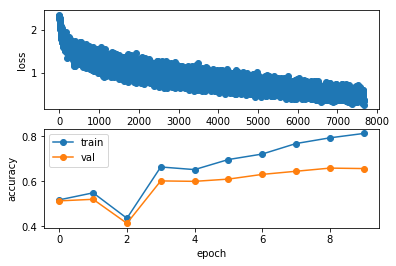

In [71]:
show_solver_training(bn_solver1)

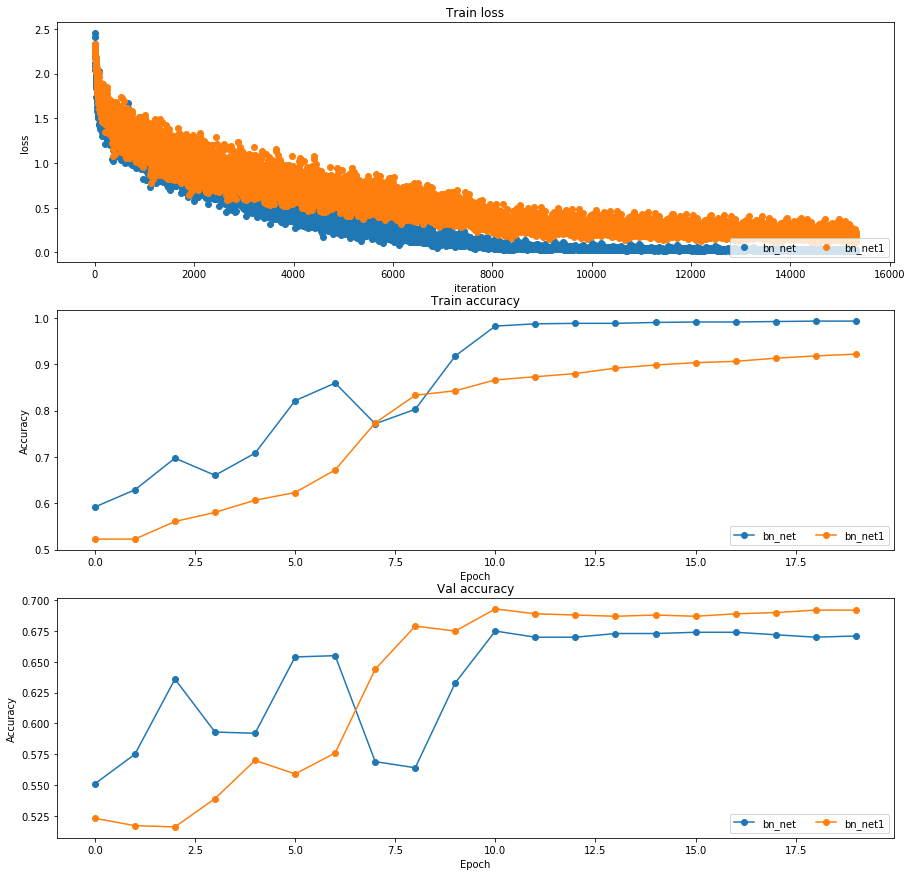

In [12]:
compare_solvers_tranings({'bn_net': bn_solver, 'bn_net1': bn_solver1})

# 3. Use small fiter

In [67]:
torch.cuda.random.manual_seed(12345)

train_stats = { }

max_count = 10

for i in range(max_count):
    lr = 10**np.random.uniform(-3, -2)
    reg = 10**np.random.uniform(-4, -2)
    
    step_size = 10
    gamma = 0.2
    num_epochs = 26
    
    #
    sf_model = models.SmallFilterNet().type(dtype)
    sf_loss_fn = nn.CrossEntropyLoss().type(dtype)
    #sf_model.apply(reset)

    sf_optimizer = optim.SGD(sf_model.parameters(), lr=lr, momentum=0.9, weight_decay=reg)
    sf_lr_scheduler = lr_scheduler.StepLR(sf_optimizer, step_size=step_size, gamma=gamma)
    #sf_lr_scheduler = None
    
    sf_solver = solver.ClassificationSolver(loader_train=loader_train, loader_val=loader_val,
                                          model=sf_model,
                                          loss_fn=sf_loss_fn,
                                          optimizer=sf_optimizer,
                                          scheduler=sf_lr_scheduler,
                                          dtype=dtype,
                                          num_epochs=num_epochs,
                                          verbose=False
                                         )

    sf_solver.train()
    small_filter_solver = sf_solver
    
    train_stats[(lr, reg)] = (small_filter_solver.train_acc_history, small_filter_solver.val_acc_history, small_filter_solver.loss_history)
    print('val accuracy: %f, train accuracy: %f, final loss: %f, lr: %e, reg: %e' % (
        small_filter_solver.val_acc_history[-1], small_filter_solver.train_acc_history[-1], small_filter_solver.loss_history[-1], lr, reg))

KeyboardInterrupt: 

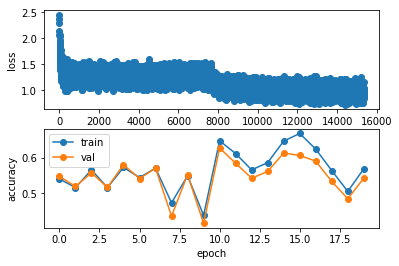

In [62]:
show_solver_training(sf_solver)

In [ ]:
# train records

max_count = 10

for i in range(max_count):
    lr = 10**np.random.uniform(-5, -2)
    reg = 10**np.random.uniform(-6, -1)

    step_size = 10
    gamma = 0.2
    num_epochs = 5
    
val accuracy: 0.619000, train accuracy: 0.621094, final loss: 1.074145, lr: 1.358590e-04, reg: 2.975939e-02
val accuracy: 0.676000, train accuracy: 0.775391, final loss: 0.533045, lr: 2.935808e-04, reg: 1.122454e-02
val accuracy: 0.708000, train accuracy: 0.832031, final loss: 0.430490, lr: 2.090484e-05, reg: 2.235820e-04
val accuracy: 0.698000, train accuracy: 0.830078, final loss: 0.329579, lr: 5.806601e-05, reg: 1.746921e-06
val accuracy: 0.709000, train accuracy: 0.936523, final loss: 0.078755, lr: 2.313033e-03, reg: 7.533011e-04
val accuracy: 0.754000, train accuracy: 0.932617, final loss: 0.149922, lr: 7.041791e-05, reg: 1.301736e-03
val accuracy: 0.756000, train accuracy: 0.965820, final loss: 0.068617, lr: 2.210942e-04, reg: 1.251856e-06
val accuracy: 0.758000, train accuracy: 0.982422, final loss: 0.046983, lr: 2.440202e-04, reg: 3.536007e-06
val accuracy: 0.750000, train accuracy: 0.991211, final loss: 0.025423, lr: 3.777598e-04, reg: 1.012957e-06
val accuracy: 0.752000, train accuracy: 0.985352, final loss: 0.051095, lr: 1.820603e-05, reg: 3.563353e-03

---
max_count = 10

for i in range(max_count):
    lr = 10**np.random.uniform(-6, -3)
    reg = 10**np.random.uniform(-6, -2)

    step_size = 5
    gamma = 0.2
    num_epochs = 10
    
val accuracy: 0.429000, train accuracy: 0.455078, final loss: 1.661445, lr: 5.639095e-06, reg: 9.896115e-05
val accuracy: 0.682000, train accuracy: 0.809570, final loss: 0.393075, lr: 2.160556e-04, reg: 2.219722e-03
val accuracy: 0.687000, train accuracy: 0.919922, final loss: 0.113677, lr: 1.212092e-04, reg: 2.261297e-06
val accuracy: 0.697000, train accuracy: 0.924805, final loss: 0.132869, lr: 4.534173e-05, reg: 2.047423e-03
val accuracy: 0.704000, train accuracy: 0.991211, final loss: 0.013402, lr: 6.568539e-04, reg: 7.442359e-04
val accuracy: 0.714000, train accuracy: 0.996094, final loss: 0.012245, lr: 2.332391e-05, reg: 6.550350e-05
val accuracy: 0.717000, train accuracy: 0.995117, final loss: 0.013172, lr: 1.201781e-05, reg: 4.634316e-03
val accuracy: 0.712000, train accuracy: 0.996094, final loss: 0.010833, lr: 7.714048e-05, reg: 1.721297e-03
val accuracy: 0.714000, train accuracy: 0.998047, final loss: 0.012038, lr: 5.045642e-06, reg: 5.300107e-06
val accuracy: 0.712000, train accuracy: 0.997070, final loss: 0.015227, lr: 7.259993e-05, reg: 9.741477e-03

---
max_count = 15

for i in range(max_count):
    lr = 10**np.random.uniform(-6, -3)
    reg = 10**np.random.uniform(-6, -2)

    step_size = 10
    gamma = 0.2
    num_epochs = 10

    sf_optimizer = optim.SGD(sf_model.parameters(), lr=lr, momentum=0.9, weight_decay=reg)
    sf_lr_scheduler = lr_scheduler.StepLR(sf_optimizer, step_size=step_size, gamma=gamma)
    sf_lr_scheduler = None

val accuracy: 0.511000, train accuracy: 0.496094, final loss: 1.566164, lr: 1.408310e-05, reg: 1.113758e-03
val accuracy: 0.696000, train accuracy: 0.871094, final loss: 0.227830, lr: 3.193928e-04, reg: 2.823435e-03
val accuracy: 0.715000, train accuracy: 0.956055, final loss: 0.083766, lr: 1.039170e-04, reg: 2.380783e-06
val accuracy: 0.724000, train accuracy: 0.964844, final loss: 0.085723, lr: 5.350332e-06, reg: 1.766862e-05
val accuracy: 0.723000, train accuracy: 0.969727, final loss: 0.073746, lr: 1.775321e-05, reg: 1.520825e-03
val accuracy: 0.723000, train accuracy: 0.967773, final loss: 0.076907, lr: 1.186258e-06, reg: 4.749670e-04
val accuracy: 0.723000, train accuracy: 0.977539, final loss: 0.055853, lr: 4.464804e-05, reg: 1.362459e-03
val accuracy: 0.726000, train accuracy: 0.972656, final loss: 0.062421, lr: 4.436021e-06, reg: 2.737938e-05
val accuracy: 0.728000, train accuracy: 0.999023, final loss: 0.007861, lr: 7.850805e-04, reg: 3.641196e-04
val accuracy: 0.741000, train accuracy: 0.999023, final loss: 0.004115, lr: 2.686224e-04, reg: 7.038667e-06
val accuracy: 0.741000, train accuracy: 0.999023, final loss: 0.002732, lr: 6.829811e-04, reg: 3.207276e-06
val accuracy: 0.733000, train accuracy: 1.000000, final loss: 0.001671, lr: 8.108918e-04, reg: 8.773871e-06
val accuracy: 0.725000, train accuracy: 0.999023, final loss: 0.002597, lr: 4.958220e-06, reg: 2.384688e-04
val accuracy: 0.732000, train accuracy: 0.999023, final loss: 0.002090, lr: 2.254765e-04, reg: 4.719864e-05
val accuracy: 0.731000, train accuracy: 0.999023, final loss: 0.003462, lr: 1.382314e-04, reg: 3.396700e-03

--------------------------------------
for i in range(max_count):
    lr = 10**np.random.uniform(-5, -2)
    reg = 10**np.random.uniform(-6, -2)

    step_size = 5
    gamma = 0.2
    num_epochs = 5
    
    sf_model.apply(reset)

val accuracy: 0.717000, train accuracy: 0.856445, final loss: 0.177739, lr: 1.526739e-03, reg: 1.128967e-03
val accuracy: 0.715000, train accuracy: 0.871094, final loss: 0.162623, lr: 5.350068e-03, reg: 2.322481e-03
val accuracy: 0.707000, train accuracy: 0.811523, final loss: 0.330462, lr: 7.648409e-04, reg: 3.728406e-04
val accuracy: 0.702000, train accuracy: 0.887695, final loss: 0.087342, lr: 4.899234e-03, reg: 2.129703e-04
val accuracy: 0.698000, train accuracy: 0.818359, final loss: 0.246029, lr: 8.942790e-04, reg: 2.023933e-03
val accuracy: 0.697000, train accuracy: 0.869141, final loss: 0.058093, lr: 3.968104e-03, reg: 2.385574e-05
val accuracy: 0.693000, train accuracy: 0.875977, final loss: 0.113804, lr: 4.203720e-03, reg: 1.105757e-06
val accuracy: 0.692000, train accuracy: 0.818359, final loss: 0.087086, lr: 5.641602e-03, reg: 1.252562e-03
val accuracy: 0.691000, train accuracy: 0.910156, final loss: 0.062295, lr: 5.501341e-03, reg: 4.847367e-06
val accuracy: 0.691000, train accuracy: 0.812500, final loss: 0.183221, lr: 1.553773e-03, reg: 4.953678e-05

val accuracy: 0.686000, train accuracy: 0.792969, final loss: 0.282243, lr: 7.977062e-04, reg: 1.470737e-03
val accuracy: 0.688000, train accuracy: 0.793945, final loss: 0.399098, lr: 5.646567e-04, reg: 2.374845e-05
val accuracy: 0.676000, train accuracy: 0.861328, final loss: 0.174592, lr: 6.900336e-03, reg: 2.096740e-03

val accuracy: 0.638000, train accuracy: 0.667969, final loss: 0.789806, lr: 1.905094e-04, reg: 6.414414e-03
val accuracy: 0.606000, train accuracy: 0.715820, final loss: 0.246118, lr: 1.230909e-03, reg: 4.525664e-03
val accuracy: 0.598000, train accuracy: 0.626953, final loss: 1.026191, lr: 1.263832e-04, reg: 1.608848e-05
val accuracy: 0.623000, train accuracy: 0.646484, final loss: 0.996234, lr: 1.148229e-04, reg: 9.185649e-05
val accuracy: 0.610000, train accuracy: 0.679688, final loss: 0.842195, lr: 2.208112e-04, reg: 7.347610e-05
val accuracy: 0.647000, train accuracy: 0.789062, final loss: 0.223778, lr: 1.644549e-03, reg: 3.581282e-03
val accuracy: 0.648000, train accuracy: 0.719727, final loss: 0.739614, lr: 2.594248e-04, reg: 8.229983e-03
val accuracy: 0.627000, train accuracy: 0.756836, final loss: 0.121043, lr: 6.087767e-03, reg: 4.857383e-05
val accuracy: 0.631000, train accuracy: 0.679688, final loss: 0.710764, lr: 2.447182e-04, reg: 5.106181e-04

val accuracy: 0.453000, train accuracy: 0.454102, final loss: 1.695024, lr: 1.209167e-05, reg: 8.776621e-04
val accuracy: 0.467000, train accuracy: 0.474609, final loss: 1.646518, lr: 2.030010e-05, reg: 2.270121e-06
val accuracy: 0.535000, train accuracy: 0.527344, final loss: 1.475234, lr: 2.888826e-05, reg: 2.246716e-06
val accuracy: 0.534000, train accuracy: 0.557617, final loss: 1.377655, lr: 4.496026e-05, reg: 7.779298e-06
val accuracy: 0.558000, train accuracy: 0.518555, final loss: 1.515000, lr: 3.299808e-05, reg: 1.100673e-04
val accuracy: 0.569000, train accuracy: 0.568359, final loss: 1.367277, lr: 5.491752e-05, reg: 6.799589e-06
val accuracy: 0.577000, train accuracy: 0.592773, final loss: 1.234234, lr: 7.462673e-05, reg: 1.241506e-04
val accuracy: 0.588000, train accuracy: 0.593750, final loss: 1.259598, lr: 8.808351e-05, reg: 1.627966e-05

--
max_count = 30

for i in range(max_count):
    lr = 10**np.random.uniform(-4, -2)
    reg = 10**np.random.uniform(-6, -2)

    step_size = 13
    gamma = 0.2
    num_epochs = 10
    
    sf_model.apply(reset)
    
val accuracy: 0.768000, train accuracy: 0.997070, final loss: 0.003997, lr: 2.905038e-03, reg: 4.764615e-05
val accuracy: 0.768000, train accuracy: 0.998047, final loss: 0.001111, lr: 8.864113e-03, reg: 6.726142e-06
val accuracy: 0.760000, train accuracy: 0.995117, final loss: 0.002570, lr: 4.886068e-03, reg: 1.725608e-06

val accuracy: 0.749000, train accuracy: 0.999023, final loss: 0.003665, lr: 5.835994e-03, reg: 3.191556e-04
val accuracy: 0.748000, train accuracy: 0.999023, final loss: 0.003851, lr: 2.553605e-03, reg: 5.686497e-05
val accuracy: 0.741000, train accuracy: 0.995117, final loss: 0.006125, lr: 2.101662e-03, reg: 2.921331e-06
val accuracy: 0.741000, train accuracy: 0.990234, final loss: 0.011840, lr: 1.523127e-03, reg: 4.355892e-05

val accuracy: 0.736000, train accuracy: 0.997070, final loss: 0.006737, lr: 2.121068e-03, reg: 2.594432e-04
val accuracy: 0.735000, train accuracy: 0.998047, final loss: 0.001193, lr: 9.895809e-03, reg: 3.974508e-06
val accuracy: 0.729000, train accuracy: 0.987305, final loss: 0.034896, lr: 1.079250e-03, reg: 1.798826e-03
val accuracy: 0.725000, train accuracy: 0.975586, final loss: 0.027504, lr: 1.181698e-03, reg: 1.172088e-04
val accuracy: 0.724000, train accuracy: 0.996094, final loss: 0.007963, lr: 4.571835e-03, reg: 1.174151e-03


val accuracy: 0.713000, train accuracy: 0.982422, final loss: 0.013513, lr: 1.401784e-03, reg: 2.005444e-06
val accuracy: 0.714000, train accuracy: 0.969727, final loss: 0.039042, lr: 1.235121e-03, reg: 7.245557e-06
val accuracy: 0.701000, train accuracy: 0.898438, final loss: 0.134270, lr: 5.014756e-04, reg: 9.933426e-06
val accuracy: 0.709000, train accuracy: 0.957031, final loss: 0.038956, lr: 9.963621e-04, reg: 8.967038e-05
val accuracy: 0.687000, train accuracy: 0.895508, final loss: 0.155343, lr: 4.568947e-04, reg: 5.579452e-05
val accuracy: 0.695000, train accuracy: 0.824219, final loss: 0.448001, lr: 1.998299e-04, reg: 5.448780e-05
val accuracy: 0.692000, train accuracy: 0.878906, final loss: 0.171387, lr: 3.638891e-04, reg: 2.203410e-04
val accuracy: 0.685000, train accuracy: 0.861328, final loss: 0.136330, lr: 4.028031e-04, reg: 6.234649e-04
val accuracy: 0.685000, train accuracy: 0.835938, final loss: 0.261216, lr: 3.143735e-04, reg: 8.576454e-04
val accuracy: 0.689000, train accuracy: 0.753906, final loss: 0.583208, lr: 1.331445e-04, reg: 7.850522e-05
val accuracy: 0.662000, train accuracy: 0.750000, final loss: 0.583299, lr: 1.540159e-04, reg: 2.136023e-04
val accuracy: 0.664000, train accuracy: 0.724609, final loss: 0.773486, lr: 1.085276e-04, reg: 2.482861e-05
val accuracy: 0.682000, train accuracy: 0.866211, final loss: 0.145698, lr: 3.818687e-04, reg: 2.050274e-04
val accuracy: 0.688000, train accuracy: 0.943359, final loss: 0.031282, lr: 1.013129e-03, reg: 1.187865e-05
val accuracy: 0.677000, train accuracy: 0.910156, final loss: 0.096634, lr: 3.865804e-03, reg: 5.076405e-03

val accuracy: 0.647000, train accuracy: 0.724609, final loss: 0.713468, lr: 1.169450e-04, reg: 5.067801e-03
val accuracy: 0.658000, train accuracy: 0.768555, final loss: 0.403099, lr: 2.185561e-04, reg: 5.065327e-06
val accuracy: 0.663000, train accuracy: 0.849609, final loss: 0.143328, lr: 5.347354e-04, reg: 1.533745e-05

---
for i in range(max_count):
    lr = 10**np.random.uniform(-3, -2)
    reg = 10**np.random.uniform(-6, -2)

    step_size = 13
    gamma = 0.2
    num_epochs = 30

val accuracy: 0.778000, train accuracy: 0.999023, final loss: 0.027831, lr: 5.752174e-03, reg: 5.000414e-03
val accuracy: 0.770000, train accuracy: 1.000000, final loss: 0.027895, lr: 8.540242e-03, reg: 5.001645e-03
val accuracy: 0.766000, train accuracy: 0.999023, final loss: 0.000860, lr: 5.173109e-03, reg: 6.792560e-06
val accuracy: 0.764000, train accuracy: 0.998047, final loss: 0.000718, lr: 4.779632e-03, reg: 2.516432e-05
val accuracy: 0.758000, train accuracy: 0.999023, final loss: 0.002435, lr: 1.987299e-03, reg: 5.310129e-06
val accuracy: 0.758000, train accuracy: 0.997070, final loss: 0.003172, lr: 1.550629e-03, reg: 2.795448e-06

val accuracy: 0.754000, train accuracy: 0.996094, final loss: 0.000581, lr: 7.103239e-03, reg: 2.424938e-06
val accuracy: 0.752000, train accuracy: 0.996094, final loss: 0.000917, lr: 7.100757e-03, reg: 6.336569e-05
val accuracy: 0.737000, train accuracy: 0.998047, final loss: 0.001025, lr: 5.905068e-03, reg: 1.432369e-04
val accuracy: 0.722000, train accuracy: 0.999023, final loss: 0.004373, lr: 1.311240e-03, reg: 2.370005e-06

---
max_count = 10

for i in range(max_count):
    lr = 10**np.random.uniform(-3, -2)
    reg = 10**np.random.uniform(-4, -2)
    
    step_size = 10
    gamma = 0.2
    num_epochs = 26
    
val accuracy: 0.761000, train accuracy: 0.998047, final loss: 0.009879, lr: 1.962494e-03, reg: 2.050679e-03
val accuracy: 0.754000, train accuracy: 0.999023, final loss: 0.011465, lr: 3.996813e-03, reg: 2.548878e-03
val accuracy: 0.764000, train accuracy: 0.999023, final loss: 0.018442, lr: 8.647048e-03, reg: 3.045161e-03
val accuracy: 0.750000, train accuracy: 0.999023, final loss: 0.044461, lr: 4.453265e-03, reg: 7.477432e-03
val accuracy: 0.769000, train accuracy: 0.999023, final loss: 0.002916, lr: 4.225326e-03, reg: 3.759046e-04
val accuracy: 0.749000, train accuracy: 0.998047, final loss: 0.002433, lr: 3.290288e-03, reg: 2.246344e-04
val accuracy: 0.764000, train accuracy: 0.998047, final loss: 0.011408, lr: 5.329769e-03, reg: 1.884878e-03
val accuracy: 0.741000, train accuracy: 0.995117, final loss: 0.007570, lr: 1.256218e-03, reg: 3.015248e-04
val accuracy: 0.762000, train accuracy: 0.999023, final loss: 0.040634, lr: 1.396607e-03, reg: 7.864990e-03

# Avoid overfitting

Batchnorm helps to train nerual network, but may easily lead to overfitting.. How to solve?

(Principle: guide the learning to learn the real target? and more princiles?)
* more data -> e.g. collect more images, or image augmentation(add noise, rotate etc)
* more or better regularization term(e.g L2, L1 etc ?)
* multi-task training
* unsupervised pre-training??
* unsupervised term in the training criterio??
* consider different function families(or neural network architechtures) -> e.g. droputout-net?
* supervised pre-training -> e.g. transfer learing
* self-suprvised pre-training



# Hard to train?

* some bugs? e.g. incorrect graident implementation?
* batchnorm
* tune for finding hyper-paramters
* just the net capacity is very low?